# Curate training data for promiscuity model

Here, I only included the EnzymeCAGE_train.csv but not the EnzymeCAGE_valid.csv. Maybe in the future, I will/should include both?!

In [42]:
# Data from EnzymeCAGE

import pandas as pd

df_train = pd.read_csv('/nvme2/helen/masterthesis/manuscript/data/EnzymeCAGE_train.csv')
df_valid = pd.read_csv('/nvme2/helen/masterthesis/manuscript/data/EnzymeCAGE_valid.csv',  low_memory=False)
df_protein = pd.read_pickle('/home/helen/cec_degrader/generalize/data/protein.pkl')

# Combine validation and training data
df_CAGE = pd.concat([df_train, df_valid], axis=0).reset_index(drop=True)

### Filter down to all promiscuous enzymes

In [21]:
# Positive samples only
df = df_CAGE[df_CAGE['Label'] == 1]

# Add EC number from protein.pkl if not present 
ec_mapping = df_protein.groupby('Entry')['EC number'].apply(list).to_dict()
df['EC number'] = df['UniprotID'].map(ec_mapping)
df['EC number'] = df['EC number'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

# Filter to (catalytically) promiscuous enzymes (i.e. present more than once in df)
filtered_df = df[df['UniprotID'].duplicated(keep=False)]
df  = filtered_df.sort_values(by='UniprotID')
df = df.reset_index(drop=True)

# Split reaction SMILEs into substrates and products
df[['substrates', 'products']] = df['SMILES'].str.split('>>', expand=True)

# Remove H20 and H+ as a substrate
def remove_water_and_protons(smiles):
    if pd.isna(smiles):
        return smiles
    parts = smiles.split('.')
    parts = [p for p in parts if p not in ('[H]O[H]', '[H+]', '[H]')]
    return '.'.join(parts)

df['substrates'] = df['substrates'].apply(remove_water_and_protons)

# Number of substrates and products per entry
df['number_substrates'] = df['substrates'].str.count('\.') + 1
df['number_products'] = df['products'].str.count('\.') + 1

#df.to_pickle('data/EnzymeCAGE_train_all_promiscuous.pkl')

<>:28: SyntaxWarning: invalid escape sequence '\.'
<>:29: SyntaxWarning: invalid escape sequence '\.'
<>:28: SyntaxWarning: invalid escape sequence '\.'
<>:29: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipykernel_309203/3930490955.py:28: SyntaxWarning: invalid escape sequence '\.'
  df['number_substrates'] = df['substrates'].str.count('\.') + 1
/tmp/ipykernel_309203/3930490955.py:29: SyntaxWarning: invalid escape sequence '\.'
  df['number_products'] = df['products'].str.count('\.') + 1
/tmp/ipykernel_309203/3930490955.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EC number'] = df['UniprotID'].map(ec_mapping)
/tmp/ipykernel_309203/3930490955.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

### Filter down to E.C class 3.1

In [8]:
import pandas as pd

df = pd.read_pickle('data/EnzymeCAGE_train_all_promiscuous.pkl')

# Filter to only promiscuous esterases
uniprot_with_3_1 = df.loc[df['EC number'].fillna('').str.startswith('3.1.'), 'UniprotID'].unique()
df_EC3p1 = df[df['UniprotID'].isin(uniprot_with_3_1)].copy()
df_EC3p1 = df_EC3p1.reset_index(drop=True)


### Filter down to all substrate promiscuous enzymes

In [22]:

# Create cannonical substrate strings to detect duplicate substrates 
def canonical_substrates(substrates):
    parts = substrates.split('.')
    parts = sorted([p.strip() for p in parts])
    return '.'.join(parts)

df['substrates_canonical'] = df['substrates'].str.strip().apply(canonical_substrates)

# For each UniprotID, remove catalytically promiscuous enzymes by filtering out rows with identical substrates
def filter_unique_substrates(group):
    counts = group['substrates_canonical'].value_counts()
    unique_substrates = counts[counts == 1].index
    return group[group['substrates_canonical'].isin(unique_substrates)]

df_unique = df.groupby('UniprotID', group_keys=False).apply(filter_unique_substrates).reset_index(drop=True)
df_unique = df_unique.drop(columns=['substrates_canonical'])
df_unique = df_unique[df_unique['UniprotID'].duplicated(keep=False)]
df_unique = df_unique.sort_values(by='UniprotID')


/tmp/ipykernel_309203/2626430180.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_unique = df.groupby('UniprotID', group_keys=False).apply(filter_unique_substrates).reset_index(drop=True)


In [67]:

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG, display

# SMARTS for ester group
ester_smarts = "[CX3](=O)[OX2H0][#6]"
ester_smarts_list = [
    "[CX3](=O)[OX2H0][#6]",       # classic carboxylic ester
    "[OX2H0][CX3](=O)[#6]",       # same but reversed
    "[$([OX2][P](=O)(O)(O))]",    # phosphate monoester
    "[$([OX2][P](=O)([OX2])[O])]",# phosphate diester
    "[$([OX2][P](=O)([OX2])([OX2]))]" # phosphate triester
]
ester_query = Chem.MolFromSmarts(ester_smarts)
ester_queries = [Chem.MolFromSmarts(s) for s in ester_smarts_list]

# Draw molecules with optional bond highlights
def draw_molecule_with_bond_highlight(mol, highlight_bonds=None, legend=""):
    if mol is None:
        return
    drawer = rdMolDraw2D.MolDraw2DSVG(350, 300)
    highlight_bonds = highlight_bonds or []

    highlight_atoms = set()
    for bond_idx in highlight_bonds:
        bond = mol.GetBondWithIdx(bond_idx)
        highlight_atoms.add(bond.GetBeginAtomIdx())
        highlight_atoms.add(bond.GetEndAtomIdx())

    rdMolDraw2D.PrepareAndDrawMolecule(
        drawer, mol,
        highlightAtoms=list(highlight_atoms),
        highlightBonds=highlight_bonds,
        legend=legend
    )
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    display(SVG(svg))


# Check if atoms in a match are connected
def is_connected_path(mol, atom_indices):
    try:
        _ = rdmolops.PathToSubmol(mol, atom_indices)
        return True
    except:
        return False

# Remove H20 and H+ as a substrate
def remove_water_and_protons(smiles_list):
    filtered = [smi for smi in smiles_list if smi not in ['[H]O[H]', '[H+]', '[H]', 'O']]
    if not filtered:
        return None 
    return filtered

# Main function with visualization
def get_broken_ester_substrates(row, ester_queries, debug=False):
    try:
        reaction_smiles = row['SMILES']
        uniprot = row.get('uniprot', 'N/A')
        rhea_id = row.get('rhea_id', 'N/A')

        reactants_part, products_part = reaction_smiles.split(">>")
        reactant_smis = remove_water_and_protons(reactants_part.split("."))
        product_smis = remove_water_and_protons(products_part.split("."))

        if not reactant_smis or not product_smis:
            return None

        product_mols = [Chem.MolFromSmiles(smi) for smi in product_smis if smi]
        broken_substrates = []

        for reactant_smi in reactant_smis:
            reactant_mol = Chem.MolFromSmiles(reactant_smi)
            if not reactant_mol:
                continue

            ester_broken = False

            for ester_query in ester_queries:
                ester_matches = reactant_mol.GetSubstructMatches(ester_query)
                for match in ester_matches:
                    if not is_connected_path(reactant_mol, list(match)):
                        match_smiles = Chem.MolFragmentToSmiles(reactant_mol, atomsToUse=list(match))
                        print(f"⚠️ DISCONNECTED MATCH | UniProt: {uniprot}, RHEA: {rhea_id}, Match SMILES: {match_smiles}")
                        continue

                    ester_frag = Chem.PathToSubmol(reactant_mol, list(match))

                    found_in_products = any(
                        p_mol and p_mol.HasSubstructMatch(ester_frag)
                        for p_mol in product_mols
                    )

                    if debug:
                        print(f"🔎 Ester match {match} {'✓ found' if found_in_products else '✗ NOT found'} in products.")

                    if not found_in_products:
                        ester_broken = True
                        break  # one broken ester is enough

                if ester_broken:
                    break

            if ester_broken:
                broken_substrates.append(reactant_smi)

        return ".".join(broken_substrates) if broken_substrates else None

    except Exception as e:
        if debug:
            print(f"⚠️ Error: {e}")
        return None




# Assuming your dataframe is called `df` and has the columns
df = df_EC3p1.copy()
df = df.head(20)
df["broken_ester_substrates"] = df.apply(lambda row: get_broken_ester_substrates(row, ester_queries, debug=True), axis=1)
df


🔎 Ester match (23, 24, 22, 21) ✗ NOT found in products.
🔎 Ester match (3, 4, 5, 6) ✗ NOT found in products.
🔎 Ester match (1, 2, 3, 4) ✓ found in products.
🔎 Ester match (1, 2, 3, 4) ✓ found in products.
🔎 Ester match (7, 8, 9, 10) ✓ found in products.
🔎 Ester match (38, 39, 37, 11) ✓ found in products.
🔎 Ester match (9, 7, 8, 6) ✓ found in products.
🔎 Ester match (37, 38, 39, 40) ✓ found in products.
🔎 Ester match (13,) ✓ found in products.
🔎 Ester match (17,) ✓ found in products.
🔎 Ester match (22,) ✓ found in products.
🔎 Ester match (30,) ✓ found in products.
🔎 Ester match (13,) ✓ found in products.
🔎 Ester match (17,) ✓ found in products.
🔎 Ester match (1, 2, 3, 4) ✓ found in products.
🔎 Ester match (32, 34, 31, 5) ✓ found in products.
🔎 Ester match (7,) ✓ found in products.
🔎 Ester match (11,) ✓ found in products.
🔎 Ester match (16,) ✓ found in products.
🔎 Ester match (24,) ✓ found in products.
🔎 Ester match (7,) ✓ found in products.
🔎 Ester match (11,) ✓ found in products.
🔎 Este

RHEA_ID DIRECTION  MASTER_ID   UniprotID  \
0     53744        UN      53744  A0A023W421   
1     13953        UN      13953  A0A023W421   
2     67452        UN      67452  A0A0A7EQR3   
3     67453        LR      67452  A0A0A7EQR3   
4     45632        UN      45632  A0A0G2JXT6   
5     39019        UN      39019  A0A0G2JXT6   
6     12316        UN      12316  A0A0G2JXT6   
7     42328        UN      42328  A0A0G2JXT6   
8     60392        UN      60392  A0A0H2V660   
9     60396        UN      60396  A0A0H2V660   
10    60404        UN      60404  A0A0H2V660   
11    60400        UN      60400  A0A0H2V660   
12    60408        UN      60408  A0A0H2V660   
13    60388        UN      60388  A0A0H2V660   
14    59257        LR      59256  A0A0H2V760   
15    30111        UN      30111  A0A0H2V760   
16    59264        UN      59264  A0A0H2V760   
17    59260        UN      59260  A0A0H2V760   
18    60413        LR      60412  A0A0H2V871   
19    60384        UN      60384  A0A0H2V871   

                                               SMILES  EC number  \
0   *P(=O)([O-])OC[C@H]1O[C@@H](N2C=NC3=C(N)N=CN=C...   3.1.1.96   
1   *[C@@H]([NH3+])C(=O)O[C@H]1[C@@H](O)[C@H](N2C=...   3.1.1.96   
2   *OC(=O)[C@H]1O[C@H](O*)[C@H](O)[C@@H](O)[C@@H]...  3.1.1.117   
3   *OC(=O)[C@H]1O[C@H](O*)[C@H](O)[C@@H](O)[C@@H]...  3.1.1.117   
4   CCCCCCCC(=O)OC[C@H](COP(=O)([O-])O[C@@H]1[C@H]...   3.1.3.95   
5   *C(=O)OC[C@]([H])(COP(=O)([O-])O[C@@H]1[C@H](O...   3.1.3.95   
6   *C(=O)OC[C@]([H])(COP(=O)([O-])O[C@@H]1[C@H](O...   3.1.3.95   
7   CCCCCCCC(=O)OC[C@H](COP(=O)([O-])O[C@@H]1[C@H]...   3.1.3.95   
8   [H][C@]12COC(=O)[C@]3([H])COC(=O)[C@]([H])(COC...  3.1.1.109   
9   O=C1N[C@H](C(=O)[O-])COC(=O)[C@@H]2COC(=O)[C@H...  3.1.1.109   
10  O=C1N[C@H](C(=O)[O-])COC(=O)[C@@H]2COC(=O)[C@H...  3.1.1.109   
11  O=C1N[C@H](C(=O)[O-])COC(=O)[C@@H]2COC(=O)[C@H...  3.1.1.109   
12  O=C1N[C@H](C(=O)[O-])COC(=O)[C@H](CO)NC(=O)C2=...  3.1.1.109   
13  [H][C@]12COC(=O)[C@]3([H])COC(=O)[C@]([H])(COC...  3.1.1.109   
14  [H][C@]12COC(=O)[C@]3([H])COC(=O)[C@]([H])(COC...  3.1.1.108   
15  [H][C@]12COC(=O)[C@]3([H])COC(=O)[C@]([H])(COC...  3.1.1.108   
16  O=C1N[C@H](C(=O)[O-])COC(=O)[C@H](CO)NC(=O)C2=...  3.1.1.108   
17  O=C1N[C@H](C(=O)[O-])COC(=O)[C@@H]2COC(=O)[C@H...  3.1.1.108   
18  O=C(N[C@H]1COC(=O)[C@@H](NC(=O)C2=CC=CC(O)=C2O...  3.1.1.107   
19  O=C(N[C@H]1COC(=O)[C@@H](NC(=O)C2=CC=CC(O)=C2O...  3.1.1.107   

                                      CANO_RXN_SMILES  \
0   *P(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H...   
1   *[C@@H](N)C(=O)O[C@H]1[C@@H](O)[C@H](n2cnc3c(N...   
2   *OC(=O)[C@H]1O[C@H](O*)[C@H](O)[C@@H](O)[C@@H]...   
3   *OC(=O)[C@H]1O[C@H](O*)[C@H](O)[C@@H](O)[C@@H]...   
4   CCCCCCCC(=O)OC[C@H](COP(=O)(O)O[C@@H]1[C@H](O)...   
5   *C(=O)OC[C@H](COP(=O)(O)O[C@@H]1[C@H](O)[C@H](...   
6   *C(=O)OC[C@H](COP(=O)(O)O[C@@H]1[C@H](O)[C@H](...   
7   CCCCCCCC(=O)OC[C@H](COP(=O)(O)O[C@@H]1[C@H](O)...   
8   O.O=C1N[C@H]2COC(=O)[C@@H]3COC(=O)[C@H](COC2=O...   
9   O.O=C1N[C@H](C(=O)O)COC(=O)[C@@H]2COC(=O)[C@H]...   
10  O.O=C1N[C@H](C(=O)O)COC(=O)[C@@H]2COC(=O)[C@H]...   
11  O.O=C1N[C@H](C(=O)O)COC(=O)[C@@H]2COC(=O)[C@H]...   
12  O.O=C1N[C@H](C(=O)O)COC(=O)[C@H](CO)NC(=O)c2cc...   
13  O.O=C1N[C@H]2COC(=O)[C@@H]3COC(=O)[C@H](COC2=O...   
14  O.O=C1N[C@H]2COC(=O)[C@@H]3COC(=O)[C@H](COC2=O...   
15  O.O.O.O=C1N[C@H]2COC(=O)[C@@H]3COC(=O)[C@H](CO...   
16  O.O=C1N[C@H](C(=O)O)COC(=O)[C@H](CO)NC(=O)c2cc...   
17  O.O=C1N[C@H](C(=O)O)COC(=O)[C@@H]2COC(=O)[C@H]...   
18  O.O=C(N[C@H]1COC(=O)[C@@H](NC(=O)c2cccc(O)c2O)...   
19  O.O=C(N[C@H]1COC(=O)[C@@H](NC(=O)c2cccc(O)c2O)...   

                                             sequence  \
0   MKLVVQRVTDASVTVDGAVAGRIGPGIMALVGVTHEDTEEDAAYLA...   
1   MKLVVQRVTDASVTVDGAVAGRIGPGIMALVGVTHEDTEEDAAYLA...   
2   MFKPSFVALALVSYATAQASAPQWGQCGGIGWTGPTACPSGWACQQ...   
3   MFKPSFVALALVSYATAQASAPQWGQCGGIGWTGPTACPSGWACQQ...   
4   MEHIRTTKVEQVKLLDRFSTNNKSLTGTLYLTATHLLFIDAHQKET...   
5   MEHIRTTKVEQVKLLDRFSTNN

In [ ]:


# For those entries which only have 1 substrate left after removing H and H20 we don't need to do anything
# Use atom-atom matching



In [11]:
from rdkit import Chem

def detect_ester_cleavage(reactant_smiles, product_smiles):
    ester_pattern = Chem.MolFromSmarts('[CX3](=O)[OX2H0][#6]')

    reactant = Chem.MolFromSmiles(reactant_smiles)
    product = Chem.MolFromSmiles(product_smiles)

    if not reactant or not product:
        return False

    # Find ester bonds in reactant
    ester_matches = reactant.GetSubstructMatches(ester_pattern)

    for match in ester_matches:
        c_atom, db_o_atom, o_atom, r_atom = match

        # Get atom map numbers
        c_map = reactant.GetAtomWithIdx(c_atom).GetAtomMapNum()
        o_map = reactant.GetAtomWithIdx(o_atom).GetAtomMapNum()
        r_map = reactant.GetAtomWithIdx(r_atom).GetAtomMapNum()

        # Find these atoms in product by atom map
        mapped_atoms = {a.GetAtomMapNum(): a for a in product.GetAtoms() if a.GetAtomMapNum() != 0}

        # Check if ester bond C–O is still intact in product
        if c_map in mapped_atoms and o_map in mapped_atoms:
            prod_c = mapped_atoms[c_map]
            prod_o = mapped_atoms[o_map]
            bond = product.GetBondBetweenAtoms(prod_c.GetIdx(), prod_o.GetIdx())
            if bond is None:
                return True  # bond was broken
        else:
            return True  # atoms not found → likely cleavage

    return False  # all ester bonds survived

def parse_mapped_reaction(mapped_rxn_smiles):
    reactant_smiles, product_smiles = mapped_rxn_smiles.split(">>")
    reactants = reactant_smiles.split(".")
    products = product_smiles.split(".")
    return reactants, products


df = df_EC3p1.copy()

for rxn in df['atom_mapped_SMILES']:
    reactants, products = parse_mapped_reaction(rxn)
    for r in reactants:
        for p in products:
            if detect_ester_cleavage(r, p):
                print(f"Ester cleavage detected: {r} → {p}")


Ester cleavage detected: [*:1][P:2](=[O:3])([O-:4])[O:5][CH2:6][C@H:7]1[O:8][C@@H:9]([n:10]2[cH:11][n:12][c:13]3[c:14]([NH2:15])[n:16][cH:17][n:18][c:19]23)[C@H:20]([OH:21])[C@@H:22]1[O:23][C:27]([CH2:26][NH3+:25])=[O:28] → [*:1][P:2](=[O:3])([O-:4])[O:5][CH2:6][C@H:7]1[O:8][C@@H:9]([n:10]2[cH:11][n:12][c:13]3[c:14]([NH2:15])[n:16][cH:17][n:18][c:19]23)[C@H:20]([OH:21])[C@@H:22]1[OH:23]
Ester cleavage detected: [*:1][P:2](=[O:3])([O-:4])[O:5][CH2:6][C@H:7]1[O:8][C@@H:9]([n:10]2[cH:11][n:12][c:13]3[c:14]([NH2:15])[n:16][cH:17][n:18][c:19]23)[C@H:20]([OH:21])[C@@H:22]1[O:23][C:27]([CH2:26][NH3+:25])=[O:28] → [H+:24]
Ester cleavage detected: [*:1][P:2](=[O:3])([O-:4])[O:5][CH2:6][C@H:7]1[O:8][C@@H:9]([n:10]2[cH:11][n:12][c:13]3[c:14]([NH2:15])[n:16][cH:17][n:18][c:19]23)[C@H:20]([OH:21])[C@@H:22]1[O:23][C:27]([CH2:26][NH3+:25])=[O:28] → [NH3+:25][CH2:26][C:27](=[O:28])[O-:29]
Ester cleavage detected: [*:1][P:2](=[O:3])([O-:4])[O:5][CH2:6][C@H:7]1[O:8][C@@H:9]([n:10]2[cH:11][n:12][c:13]3[c

In [43]:
# Positive samples only
df = df_CAGE[df_CAGE['Label'] == 1]

# Add EC number from protein.pkl if not present 
ec_mapping = df_protein.groupby('Entry')['EC number'].apply(list).to_dict()
df['EC number'] = df['UniprotID'].map(ec_mapping)
df['EC number'] = df['EC number'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

# Filter to (catalytically) promiscuous enzymes (i.e. present more than once in df)
filtered_df = df[df['UniprotID'].duplicated(keep=False)]
df  = filtered_df.sort_values(by='UniprotID')
df = df.reset_index(drop=True)

# Split reaction SMILEs into substrates and products
df[['substrates', 'products']] = df['SMILES'].str.split('>>', expand=True)

# Filter to only promiscuous esterases
uniprot_with_3_1 = df.loc[df['EC number'].fillna('').str.startswith('3.1.'), 'UniprotID'].unique()
df_EC3p1 = df[df['UniprotID'].isin(uniprot_with_3_1)].copy()
df_EC3p1 = df_EC3p1.reset_index(drop=True)


/tmp/ipykernel_321945/1852116203.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EC number'] = df['UniprotID'].map(ec_mapping)
/tmp/ipykernel_321945/1852116203.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EC number'] = df['EC number'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)


In [46]:

from rxnmapper import RXNMapper
import pandas as pd
import time

rxn_mapper = RXNMapper()
batch_size = 16  # adjust depending on your GPU
mapped_smiles = []

for i in range(0, len(df_EC3p1), batch_size):
    batch = df_EC3p1['SMILES'].iloc[i:i + batch_size].tolist()
    try:
        results = rxn_mapper.get_attention_guided_atom_maps(batch)
        mapped_smiles.extend([r['mapped_rxn'] for r in results])
    except Exception as e:
        print(f"Error at batch {i}: {e}")
        mapped_smiles.extend([None] * len(batch))  # mark failed mappings

df_EC3p1['atom_mapped_SMILES'] = mapped_smiles


df = df_EC3p1.copy()
df = df.head(100)

In [84]:
df.tail(30)
df.atom_mapped_SMILES[76]

'[CH3:1][CH2:2][CH2:3][CH2:4][CH2:5]/[CH:6]=[CH:7]\\[CH2:8]/[CH:9]=[CH:10]\\[CH2:11]/[CH:12]=[CH:13]\\[CH2:14]/[CH:15]=[CH:16]\\[CH2:17][CH2:18][CH2:19][C:20](=[O:21])[O:43][C@H:42]([CH2:41][O:40][C:38]([CH2:37][CH2:36][CH2:35][CH2:34][CH2:33][CH2:32][CH2:31][CH2:30][CH2:29][CH2:28][CH2:27][CH2:26][CH2:25][CH2:24][CH3:23])=[O:39])[CH2:44][O:45][P:46](=[O:47])([O-:48])[O:49][CH2:50][CH2:51][N+:52]([CH3:53])([CH3:54])[CH3:55].[OH2:22]>>[CH3:1][CH2:2][CH2:3][CH2:4][CH2:5]/[CH:6]=[CH:7]\\[CH2:8]/[CH:9]=[CH:10]\\[CH2:11]/[CH:12]=[CH:13]\\[CH2:14]/[CH:15]=[CH:16]\\[CH2:17][CH2:18][CH2:19][C:20](=[O:21])[O-:22].[CH3:23][CH2:24][CH2:25][CH2:26][CH2:27][CH2:28][CH2:29][CH2:30][CH2:31][CH2:32][CH2:33][CH2:34][CH2:35][CH2:36][CH2:37][C:38](=[O:39])[O:40][CH2:41][C@@H:42]([OH:43])[CH2:44][O:45][P:46](=[O:47])([O-:48])[O:49][CH2:50][CH2:51][N+:52]([CH3:53])([CH3:54])[CH3:55].[H+:56]'

((19, 20, 21, 22), (25, 41, 24, 23))
c_idx 19
o_idx 21
r_idx 22
c_map 20
o_map 43
r_map 42
{1: <rdkit.Chem.rdchem.Atom object at 0x7fe0654b3d80>, 2: <rdkit.Chem.rdchem.Atom object at 0x7fe0654b3ed0>, 3: <rdkit.Chem.rdchem.Atom object at 0x7fe0654b3840>, 4: <rdkit.Chem.rdchem.Atom object at 0x7fe0654b3920>, 5: <rdkit.Chem.rdchem.Atom object at 0x7fe0654b3450>, 6: <rdkit.Chem.rdchem.Atom object at 0x7fe0654b3370>, 7: <rdkit.Chem.rdchem.Atom object at 0x7fe0654b3530>, 8: <rdkit.Chem.rdchem.Atom object at 0x7fe0654b3290>, 9: <rdkit.Chem.rdchem.Atom object at 0x7fe0654b30d0>, 10: <rdkit.Chem.rdchem.Atom object at 0x7fe0654b2ff0>, 11: <rdkit.Chem.rdchem.Atom object at 0x7fe0654b31b0>, 12: <rdkit.Chem.rdchem.Atom object at 0x7fe0654b0ba0>, 13: <rdkit.Chem.rdchem.Atom object at 0x7fe0654b07b0>, 14: <rdkit.Chem.rdchem.Atom object at 0x7fe0654b06d0>, 15: <rdkit.Chem.rdchem.Atom object at 0x7fe0654b09e0>, 16: <rdkit.Chem.rdchem.Atom object at 0x7fe0654b03c0>, 17: <rdkit.Chem.rdchem.Atom object at

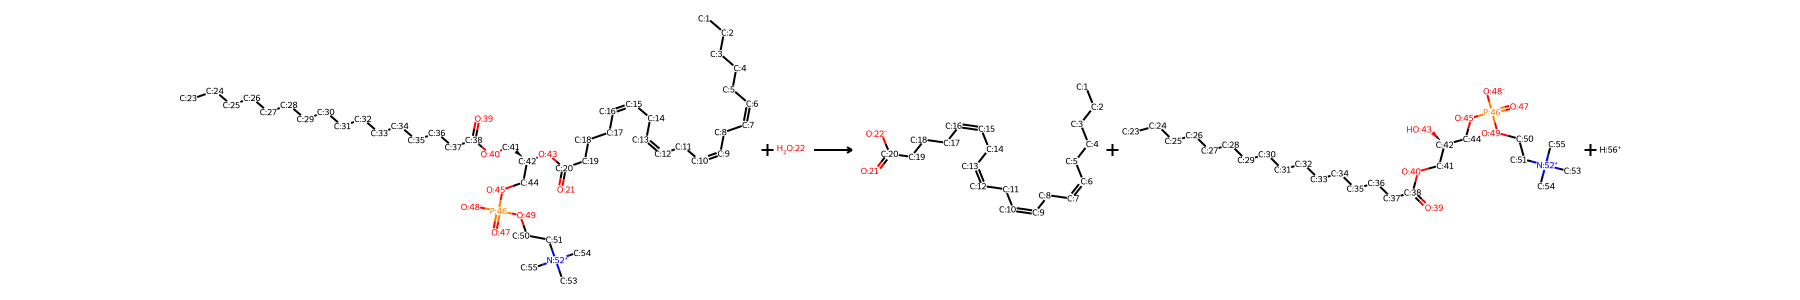

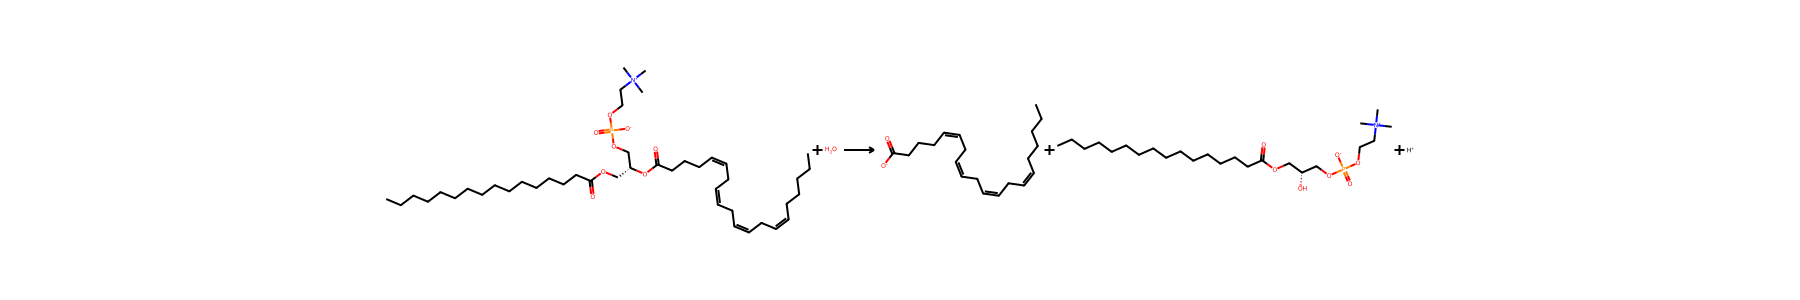

In [ ]:
from rdkit import Chem

def atoms_connected_in_products(product_mols, c_map, o_map):
    for mol in product_mols:
        if mol is None:
            continue
        # Build a mapping from atom map number to atom index
        amap_lookup = {atom.GetAtomMapNum(): atom.GetIdx() for atom in mol.GetAtoms() if atom.GetAtomMapNum() != 0}
        print(f'atom lookup {amap_lookup}')
        
        # Check if both atom map numbers are in this molecule
        if c_map in amap_lookup and o_map in amap_lookup:
            c_idx = amap_lookup[c_map]
            o_idx = amap_lookup[o_map]
            
            bond = mol.GetBondBetweenAtoms(c_idx, o_idx)
            if bond is not None:
                return True  # atoms are still connected

    return False  # not connected in any product


def detect_ester_cleaved_reactants(mapped_rxn_smiles):
    ester_pattern = Chem.MolFromSmarts('[CX3](=O)[OX2H0][#6]')
    #ester_pattern = Chem.MolFromSmarts('[C:1](=O)[O:2][C:3]')
    #ester_pattern = Chem.MolFromSmarts('[#6][CX3](=O)[OX2H0][#6]')
    #ester_pattern = Chem.MolFromSmarts('[P;!D1](=O)([OX2H0])[OX2H0][#6]')
    #ester_pattern = Chem.MolFromSmarts('[P](=O)([OX2])[OX2][#6]')
    cleaved_reactants = []

    try:
        reactant_smiles, product_smiles = mapped_rxn_smiles.split(">>")
        reactants = reactant_smiles.split(".")
        products = product_smiles.split(".")
    except Exception:
        return []

    try:
        product_mols = [Chem.MolFromSmiles(p) for p in products]
        product_atoms = {}
        for mol in product_mols:
            if mol:
                for atom  in mol.GetAtoms():
                    amap = atom.GetAtomMapNum()
                    if amap != 0:
                        product_atoms[amap] = atom 
    except Exception:
        return []

    for r_smiles in reactants:
        try:
            reactant = Chem.MolFromSmiles(r_smiles)
            if not reactant:
                continue

            ester_matches = reactant.GetSubstructMatches(ester_pattern)
            print(ester_matches)
            for match in ester_matches:
                
                if len(match) != 4:
                    continue  # skip malformed match
                c_idx, db_o_idx, o_idx, r_idx = match

                #atom_indices = list(match)
                # Key: atom map number, value: atom index from RDKit
                #amap_lookup = {reactant.GetAtomWithIdx(i).GetAtomMapNum(): i for i in atom_indices}
                #keys = list(amap_lookup.keys())
                #print(amap_lookup)

                # Now you can safely get atoms by their map numbers
                #c_idx = keys[0]
                #o_idx = keys[1]
                #r_idx = keys[2]

                print(f'c_idx {c_idx}')
                print(f'o_idx {o_idx}')
                print(f'r_idx {r_idx}')

                c_map = reactant.GetAtomWithIdx(c_idx).GetAtomMapNum()
                o_map = reactant.GetAtomWithIdx(o_idx).GetAtomMapNum()
                r_map = reactant.GetAtomWithIdx(r_idx).GetAtomMapNum()
                
                print(f'c_map {c_map}')
                print(f'o_map {o_map}')
                print(f'r_map {r_map}')   

                if None in (c_idx, o_idx, r_idx):
                    continue  # skip malformed matches

                #prod_c = product_mols.GetAtoms(c_map)
                #prod_o = product_atoms.GetAtoms(o_map)
                #prod_c = product_atoms.get(c_map)
                #prod_o = product_atoms.get(o_map)
                #print(product_atoms)
                #print(f'prod_c {prod_c}')
                #print(f'prod_o {prod_o}')   
                #print('------------')

                if not atoms_connected_in_products(product_mols, c_map, o_map):
                    print("Ester bond likely cleaved!")
                '''
                if prod_c is None or prod_o is None:
                    cleaved_reactants.append(r_smiles)
                    #break

                bond = prod_c.GetOwningMol().GetBondBetweenAtoms(prod_c.GetIdx(), prod_o.GetIdx())
                if bond is None:
                    cleaved_reactants.append(r_smiles)
                    #break
                '''  
        except Exception:
            continue

    return cleaved_reactants

#df['cleaved_reactants'] = df['atom_mapped_SMILES'].apply(detect_ester_cleaved_reactants)

reaction = '[CH3:1][CH2:2][CH2:3][CH2:4][CH2:5]/[CH:6]=[CH:7]\\[CH2:8]/[CH:9]=[CH:10]\\[CH2:11]/[CH:12]=[CH:13]\\[CH2:14]/[CH:15]=[CH:16]\\[CH2:17][CH2:18][CH2:19][C:20](=[O:21])[O:43][C@H:42]([CH2:41][O:40][C:38]([CH2:37][CH2:36][CH2:35][CH2:34][CH2:33][CH2:32][CH2:31][CH2:30][CH2:29][CH2:28][CH2:27][CH2:26][CH2:25][CH2:24][CH3:23])=[O:39])[CH2:44][O:45][P:46](=[O:47])([O-:48])[O:49][CH2:50][CH2:51][N+:52]([CH3:53])([CH3:54])[CH3:55].[OH2:22]>>[CH3:1][CH2:2][CH2:3][CH2:4][CH2:5]/[CH:6]=[CH:7]\\[CH2:8]/[CH:9]=[CH:10]\\[CH2:11]/[CH:12]=[CH:13]\\[CH2:14]/[CH:15]=[CH:16]\\[CH2:17][CH2:18][CH2:19][C:20](=[O:21])[O-:22].[CH3:23][CH2:24][CH2:25][CH2:26][CH2:27][CH2:28][CH2:29][CH2:30][CH2:31][CH2:32][CH2:33][CH2:34][CH2:35][CH2:36][CH2:37][C:38](=[O:39])[O:40][CH2:41][C@@H:42]([OH:43])[CH2:44][O:45][P:46](=[O:47])([O-:48])[O:49][CH2:50][CH2:51][N+:52]([CH3:53])([CH3:54])[CH3:55].[H+:56]'
detect_ester_cleaved_reactants(reaction)

reactant_part, product_part = reaction.split(">>")
reactants = reactant_part.split(".")
products = product_part.split(".")
rxn = rdChemReactions.ReactionFromSmarts(reaction, useSmiles=True)

scheme = Draw.ReactionToImage(rxn, subImgSize=(300, 300))
display(scheme)          # notebooks
# scheme.save("reaction.png")

# strip atom-map numbers for a cleaner picture
for mol in list(rxn.GetReactants()) + list(rxn.GetProducts()):
    for at in mol.GetAtoms():
        at.SetAtomMapNum(0)

scheme = Draw.ReactionToImage(rxn, subImgSize=(300, 300))
display(scheme)    


In [52]:
from rdkit import Chem

reaction = "[*:1][P:2](=[O:3])([O-:4])[O:5][CH2:6][C@H:7]1[O:8][C@@H:9]([n:10]2[cH:11][n:12][c:13]3[c:14]([NH2:15])[n:16][cH:17][n:18][c:19]23)[C@H:20]([OH:21])[C@@H:22]1[O:23][C:27]([CH2:26][NH3+:25])=[O:28].[OH2:29]" \
">>[*:1][P:2](=[O:3])([O-:4])[O:5][CH2:6][C@H:7]1[O:8][C@@H:9]([n:10]2[cH:11][n:12][c:13]3[c:14]([NH2:15])[n:16][cH:17][n:18][c:19]23)[C@H:20]([OH:21])[C@@H:22]1[OH:23].[H+:24].[NH3+:25][CH2:26][C:27](=[O:28])[O-:29]"

reaction = '[OH2:9].[O:1]=[C:2]1[NH:3][C@@H:4]2[C:7](=[O:8])[O:6][CH2:5][C@@H:21]([C:22](=[O:23])[O-:24])[NH:20][C:19](=[O:18])[c:59]3[cH:58][c:46]([C@@H:47]4[O:48][C@H:49]([CH2:50][OH:51])[C@@H:52]([OH:53])[C@H:54]([OH:55])[C@H:56]4[OH:57])[cH:45][c:44]4[c:60]3[O:61][Fe-3:42]35([O:15][c:14]6[cH:13][cH:12][cH:11][c:10]1[c:16]6[O:17]3)([O:41][c:40]1[c:35]([cH:36][cH:37][cH:38][c:39]1[O:62]5)[C:33](=[O:34])[NH:32][C@@H:29]([CH2:30][OH:31])[C:27](=[O:28])[O:26][CH2:25]2)[O:43]4.[H+]>>[O:1]=[C:2]([NH:3][C@@H:4]([CH2:5][OH:6])[C:7](=[O:8])[O-:9])[c:10]1[cH:11][cH:12][cH:13][c:14]([OH:15])[c:16]1[OH:17].[O:18]=[C:19]1[NH:20][C@H:21]([C:22](=[O:23])[O-:24])[CH2:25][O:26][C:27](=[O:28])[C@H:29]([CH2:30][OH:31])[NH:32][C:33](=[O:34])[c:35]2[cH:36][cH:37][cH:38][c:39]3[c:40]2[O:41][Fe-:42]2([O:43][c:44]4[cH:45][c:46]([C@@H:47]5[O:48][C@H:49]([CH2:50][OH:51])[C@@H:52]([OH:53])[C@H:54]([OH:55])[C@H:56]5[OH:57])[cH:58][c:59]1[c:60]4[O:61]2)[O:62]3'
reactant_part, product_part = reaction.split(">>")

reactants = reactant_part.split(".")
products = product_part.split(".")

# Test RDKit parsing for each molecule
for i, smi in enumerate(reactants):
    mol = Chem.MolFromSmiles(smi)
    print(f"Reactant {i}: {'✅ OK' if mol else '❌ Invalid'}")

for i, smi in enumerate(products):
    mol = Chem.MolFromSmiles(smi)
    print(f"Product {i}: {'✅ OK' if mol else '❌ Invalid'}")


Reactant 0: ✅ OK
Reactant 1: ✅ OK
Reactant 2: ✅ OK
Product 0: ✅ OK
Product 1: ✅ OK


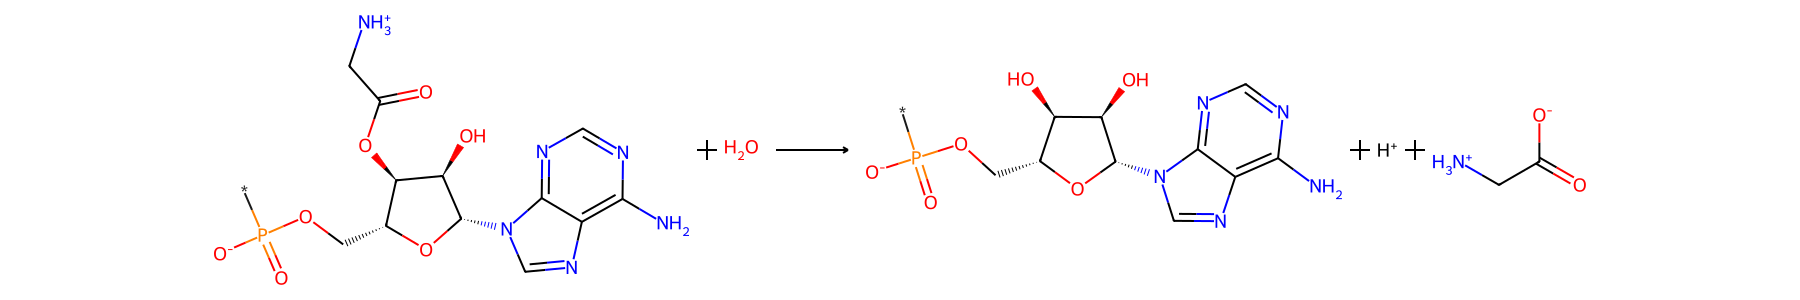

In [29]:
from rdkit.Chem import rdChemReactions, Draw


rxn_smiles = (
    "[*:1][P:2](=[O:3])([O-:4])[O:5][CH2:6][C@H:7]1[O:8][C@@H:9]"
    "([n:10]2[cH:11][n:12][c:13]3[c:14]([NH2:15])[n:16][cH:17]"
    "[n:18][c:19]23)[C@H:20]([OH:21])[C@@H:22]1[O:23][C:27]"
    "([CH2:26][NH3+:25])=[O:28].[OH2:29]"
    ">>"
    "[*:1][P:2](=[O:3])([O-:4])[O:5][CH2:6][C@H:7]1[O:8][C@@H:9]"
    "([n:10]2[cH:11][n:12][c:13]3[c:14]([NH2:15])[n:16][cH:17]"
    "[n:18][c:19]23)[C@H:20]([OH:21])[C@@H:22]1[OH:23]."
    "[H+:24].[NH3+:25][CH2:26][C:27](=[O:28])[O-:29]"
)

rxn = rdChemReactions.ReactionFromSmarts(rxn_smiles, useSmiles=True)

# strip atom-map numbers for a cleaner picture
for mol in list(rxn.GetReactants()) + list(rxn.GetProducts()):
    for at in mol.GetAtoms():
        at.SetAtomMapNum(0)

scheme = Draw.ReactionToImage(rxn, subImgSize=(300, 300))
display(scheme)          # notebooks
# scheme.save("reaction.png")


In [ ]:

# Split substrate SMILES into seperate entries
df_unique['substrates_split'] = df_unique['substrates'].str.split('.')
df_unique = df_unique.explode('substrates_split').reset_index(drop=True)
df_unique.loc[df_unique['number_substrates'] > 1]

# For each UniprotID, remove the substrates that are common to all RHEA_IDs within the same UniprotID. The logic being that these do not contribute to promiscuity because stay constant in all reactions. 
substrate_rhea_counts = df_unique.groupby(['UniprotID', 'substrates_split'])['RHEA_ID'].nunique().reset_index(name='rhea_count')
total_rhea_counts = df_unique.groupby('UniprotID')['RHEA_ID'].nunique().reset_index(name='total_rhea_count') # Find the total number of unique RHEA_IDs for each UniprotID
merged = pd.merge(substrate_rhea_counts, total_rhea_counts, on='UniprotID')
merged['appear_in_all_rhea'] = merged['rhea_count'] == merged['total_rhea_count']
substrates_to_remove = merged[merged['appear_in_all_rhea'] == True]

df_filtered = df_unique.merge(substrates_to_remove[['UniprotID', 'substrates_split']], 
                       on=['UniprotID', 'substrates_split'], how='left', indicator=True)

df_filtered = df_filtered[df_filtered['_merge'] == 'left_only'].drop(columns=['_merge'])

#df_filtered.to_pickle('data/EnzymeCAGE_train_promiscuous_substrates.pkl')
# 132'620 entries

### Promiscuous esterases (EC 3.1.X.Y)

In [ ]:
import pandas as pd

df = pd.read_pickle('data/EnzymeCAGE_train_promiscuous_substrates.pkl')

# Filter to only promiscuous esterases
uniprot_with_3_1 = df.loc[df['EC number'].fillna('').str.startswith('3.1.'), 'UniprotID'].unique()
df_filtered = df[df['UniprotID'].isin(uniprot_with_3_1)].copy()
df_filtered = df_filtered.reset_index(drop=True)
#df_filtered.to_pickle('data/EnzymeCAGE_train_promiscuous_substrates_EC3p1.pkl')

# 9'573  entries
# Contains all substrate promiscuous enzymes with EC 3.1 having removed catalytically promiscuous enzymes. 

### Thermophilic esterases (EC 3.1.X.Y)

In [ ]:
df_extremophiles = pd.read_pickle('/home/helen/cec_degrader/generalize/data/extremeophiles.pkl')
df  = pd.read_csv('data/EnzymeCAGE_train.csv')
df_protein = pd.read_pickle('/home/helen/cec_degrader/generalize/data/protein.pkl')

# Positive samples only
df = df[df['Label'] == 1]

# Add EC number from protein.pkl if not present 
ec_mapping = df_protein.groupby('Entry')['EC number'].apply(list).to_dict()
df['EC number'] = df['UniprotID'].map(ec_mapping)
df['EC number'] = df['EC number'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

# Filter to only extremophilic/thermophilic enzymes
df = df[df['UniprotID'].isin(df_extremophiles['Entry'])]

# Filter to only esterases (EC 3.1)
uniprot_with_3_1 = df.loc[df['EC number'].fillna('').str.startswith('3.1.'), 'UniprotID'].unique()
df = df[df['UniprotID'].isin(uniprot_with_3_1)].copy()
df = df.reset_index(drop=True)

# Split reaction SMILEs into substrates and products
df[['substrates', 'products']] = df['SMILES'].str.split('>>', expand=True)

# Remove H20 as a substrate
def remove_water(smiles):
    if pd.isna(smiles):
        return smiles
    parts = smiles.split('.')
    parts = [p for p in parts if p != '[H]O[H]']
    return '.'.join(parts)
df['substrates'] = df['substrates'].apply(remove_water)

# Number of substrates and products per entry
df['number_substrates'] = df['substrates'].str.count('\.') + 1
df['number_products'] = df['products'].str.count('\.') + 1

#df.to_pickle('data/EnzymeCAGE_train_extremophiles_EC3p1.pkl')

# 332 entries
# Contains all thermophilic esterases irrespective of promiscuity from the enzymeCAGE training data. 
# This is fewer entries than the number of esterases in the whole extremophiles_df which is 2232! Can we also use all of those???????